In [2]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils import plot_model
tfl = tf.keras.layers

C:\Users\ADITYA\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Loading Data
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
print("load train data set:")
train_ds = image_dataset_from_directory(r'C:\Users\ADITYA\Downloads\Alzheimer_s Dataset\train',shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,color_mode="grayscale",seed=0)
print("load test data set:")
test_ds = image_dataset_from_directory(r'C:\Users\ADITYA\Downloads\Alzheimer_s Dataset\test',shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,color_mode="grayscale",seed=0)

load train data set:
Found 5121 files belonging to 4 classes.
load test data set:
Found 1279 files belonging to 4 classes.


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


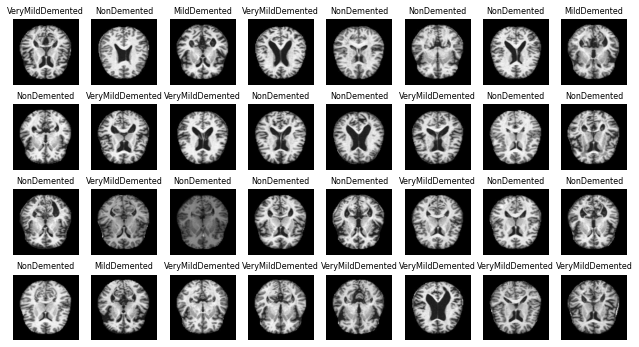

In [4]:
#plotting images with labels 

class_names = train_ds.class_names
print(f"class names are {class_names}")

fig,ax = plt.subplots(nrows=4, ncols = 8, figsize=(11, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
batch_size = 32
train_iterator = iter(train_ds)
images, labels = train_iterator.get_next()
for i in range(batch_size):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    a.set_title(class_names[labels[i]], fontsize=8)
    a.set_axis_off()

plt.show()

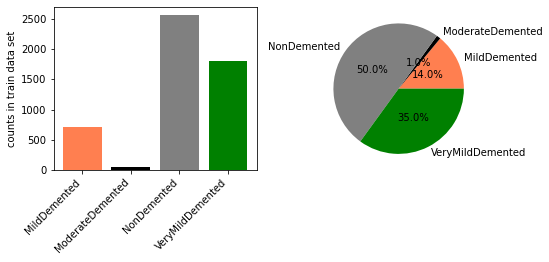

In [5]:
#Data distribution 
index = np.array([],dtype="int32");
for element in train_ds.as_numpy_iterator():
    index = np.append(index,element[1])
    
unique, counts = np.unique(index, return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
colors=['Coral', 'Black', 'gray', 'Green']
ax[0].bar(unique,counts,color=colors)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1, colors=colors)


plt.show()

In [6]:
#CNN USING SEQUENTIAL API
def conv_block(numfilters, padding='same'):
    model_cb = tf.keras.Sequential([
        tfl.Conv2D(filters=numfilters, kernel_size=3, strides=1, padding=padding, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.MaxPooling2D(pool_size=2)
    ])
    return model_cb

def dense_block(numunits):
    model_db = tf.keras.Sequential([
        tfl.Dense(numunits, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.2)
    ])
    return model_db

IMG_SHAPE = IMG_SIZE + (1,)
model_sequential = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    conv_block(16),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    tfl.Flatten(),
    dense_block(128),
    dense_block(64),
    tfl.Dense(units=4, activation='linear',name='output-layer')
])
model_sequential.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 80, 80, 16)        224       
                                                                 
 sequential_1 (Sequential)   (None, 40, 40, 32)        4768      
                                                                 
 sequential_2 (Sequential)   (None, 20, 20, 64)        18752     
                                                                 
 sequential_3 (Sequential)   (None, 10, 10, 128)       74368     
                                                                 
 sequential_4 (Sequential)   (None, 5, 5, 256)         296192    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 sequential_5 (Sequential)   (None, 128)              

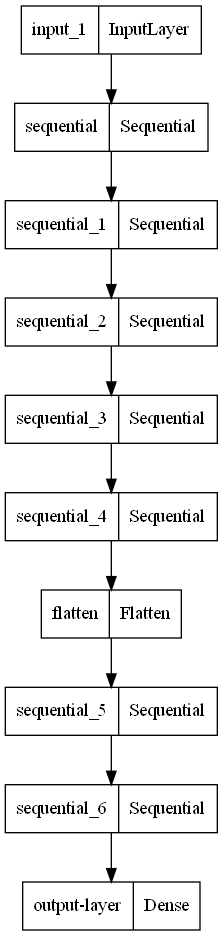

In [7]:
plot_model(model_sequential)

In [8]:
model_sequential.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [9]:
def scheduler(epoch, lr):
    return lr*(0.1**(0.05*epoch))

my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint("alzheimer_model_sequential.h5", monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

In [10]:
history_sequential = model_sequential.fit(train_ds, validation_data=test_ds,
                                          callbacks=my_callbacks, epochs=30,
                                          batch_size=32, verbose=2)
print("Finished!")

Epoch 1/30
161/161 - 110s - loss: 1.1421 - accuracy: 0.5464 - val_loss: 1.1380 - val_accuracy: 0.5770 - lr: 0.0010 - 110s/epoch - 682ms/step
Epoch 2/30
161/161 - 101s - loss: 0.6412 - accuracy: 0.7508 - val_loss: 1.4992 - val_accuracy: 0.4511 - lr: 8.9125e-04 - 101s/epoch - 627ms/step
Epoch 3/30
161/161 - 101s - loss: 0.3384 - accuracy: 0.8803 - val_loss: 1.0035 - val_accuracy: 0.6474 - lr: 7.0795e-04 - 101s/epoch - 627ms/step
Epoch 4/30
161/161 - 101s - loss: 0.1391 - accuracy: 0.9565 - val_loss: 1.1365 - val_accuracy: 0.6349 - lr: 5.0119e-04 - 101s/epoch - 628ms/step
Epoch 5/30
161/161 - 105s - loss: 0.0612 - accuracy: 0.9873 - val_loss: 1.0246 - val_accuracy: 0.6747 - lr: 3.1623e-04 - 105s/epoch - 650ms/step
Epoch 6/30
161/161 - 88s - loss: 0.0273 - accuracy: 0.9984 - val_loss: 0.8050 - val_accuracy: 0.7342 - lr: 1.7783e-04 - 88s/epoch - 544ms/step
Epoch 7/30
161/161 - 80s - loss: 0.0200 - accuracy: 0.9990 - val_loss: 0.8672 - val_accuracy: 0.7162 - lr: 8.9125e-05 - 80s/epoch - 495m

In [11]:
alzheimer_model_sequential = tf.keras.models.load_model('alzheimer_model_sequential.h5')
alzheimer_model_sequential.trainable = False
print(f"Train accuracy = {alzheimer_model_sequential.evaluate(train_ds,verbose=0)[1]*100:.2f}%")
print(f"Valid accuracy = {alzheimer_model_sequential.evaluate(test_ds,verbose=0)[1]*100:.2f}%")

Train accuracy = 100.00%
Valid accuracy = 73.42%


# TRANSFER LEARNING

# DATA PREPARATION

In [12]:
# Convert to rgb 
train_ds_rgb = train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
test_ds_rgb = test_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
IMG_SHAPE = IMG_SIZE + (3,)

#One-hot encoded
train_ds_OHE = train_ds_rgb.map(lambda x, y: (x, tf.one_hot(y, depth = 4)))
test_ds_OHE = test_ds_rgb.map(lambda x, y:  (x, tf.one_hot(y, depth=4)))

In [13]:
train_ds_rgb = train_ds_rgb.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# STEP 1 : ADD A NEW CLASSIFIER

In [14]:
def my_model(trained_model,preprocess):
    base_model = trained_model(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape = IMG_SHAPE)
    x = preprocess(inputs)
    x = base_model(x)
    
    # new layers
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(rate = 0.2)(x)
    outputs = tfl.Dense(units=4, activation= 'linear', name='classification_layer')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [15]:
import tensorflow.keras.applications.inception_v3 as inception
model = my_model(inception.InceptionV3, inception.preprocess_input)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

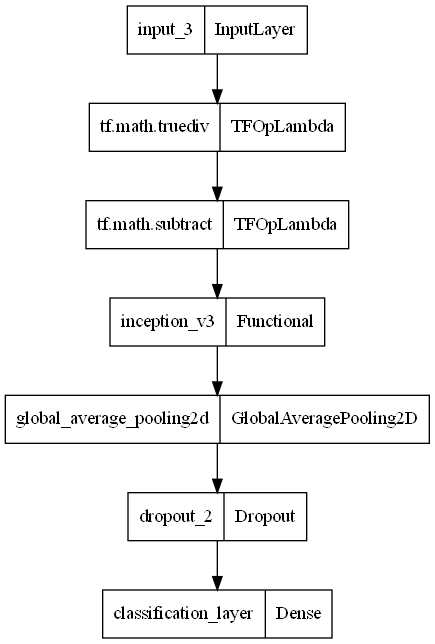

In [17]:
plot_model(model)

In [18]:
base_learning_rate = 0.001
my_metric = tf.keras.metrics.AUC(name='auc')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[my_metric])


In [19]:
class PrinterCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"EPOCH: {epoch:2d}, Trian AUC: {logs['auc']:.4f}),Val Auc: {logs['val_auc']:.4f}")
        
    def on_epoch_begin(self, epoch, logs=None):
        print('-'*50)
        print(f"STARTING EPOCH: {epoch:2d}")

In [20]:
initial_epochs = 7
model.fit(train_ds_OHE, validation_data=test_ds_OHE,
          callbacks=[PrinterCallback()], epochs=initial_epochs,
          batch_size=32, verbose=0)

--------------------------------------------------
STARTING EPOCH:  0
EPOCH:  0, Trian AUC: 0.6716),Val Auc: 0.7117
--------------------------------------------------
STARTING EPOCH:  1
EPOCH:  1, Trian AUC: 0.6850),Val Auc: 0.6776
--------------------------------------------------
STARTING EPOCH:  2
EPOCH:  2, Trian AUC: 0.6950),Val Auc: 0.7058
--------------------------------------------------
STARTING EPOCH:  3
EPOCH:  3, Trian AUC: 0.7018),Val Auc: 0.6976
--------------------------------------------------
STARTING EPOCH:  4
EPOCH:  4, Trian AUC: 0.7001),Val Auc: 0.7066
--------------------------------------------------
STARTING EPOCH:  5
EPOCH:  5, Trian AUC: 0.7054),Val Auc: 0.7047
--------------------------------------------------
STARTING EPOCH:  6
EPOCH:  6, Trian AUC: 0.7069),Val Auc: 0.7171


# Step 2: Fine-Tune by training the deep layers

In [21]:
index_base_model = 3
model.layers[index_base_model].trainable = True

num_finetuned_layers = 30
num_layers = len(model.layers[index_base_model].layers)
for layer in model.layers[index_base_model].layers[:num_layers-num_finetuned_layers]:
    layer.trainable = False

model.summary()
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

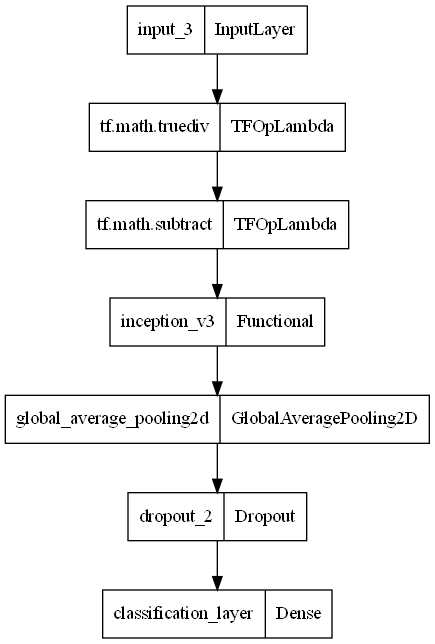

In [22]:
plot_model(model)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01*base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[my_metric])
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("alzheimer_model_inception.h5", monitor='val_auc', save_best_only=True),
    PrinterCallback()
]

In [24]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs
history = model.fit(train_ds_OHE, validation_data=test_ds_OHE,
                    callbacks=my_callbacks, epochs=total_epochs, initial_epoch=initial_epochs,
                    batch_size=32, verbose=0)
print("Finished!")

--------------------------------------------------
STARTING EPOCH:  7
EPOCH:  7, Trian AUC: 0.7801),Val Auc: 0.7551
--------------------------------------------------
STARTING EPOCH:  8
EPOCH:  8, Trian AUC: 0.8349),Val Auc: 0.7741
--------------------------------------------------
STARTING EPOCH:  9
EPOCH:  9, Trian AUC: 0.8567),Val Auc: 0.7830
--------------------------------------------------
STARTING EPOCH: 10
EPOCH: 10, Trian AUC: 0.8796),Val Auc: 0.7845
--------------------------------------------------
STARTING EPOCH: 11
EPOCH: 11, Trian AUC: 0.8941),Val Auc: 0.7895
--------------------------------------------------
STARTING EPOCH: 12
EPOCH: 12, Trian AUC: 0.9079),Val Auc: 0.7924
--------------------------------------------------
STARTING EPOCH: 13
EPOCH: 13, Trian AUC: 0.9203),Val Auc: 0.7944
--------------------------------------------------
STARTING EPOCH: 14
EPOCH: 14, Trian AUC: 0.9315),Val Auc: 0.7962
--------------------------------------------------
STARTING EPOCH: 15
EP

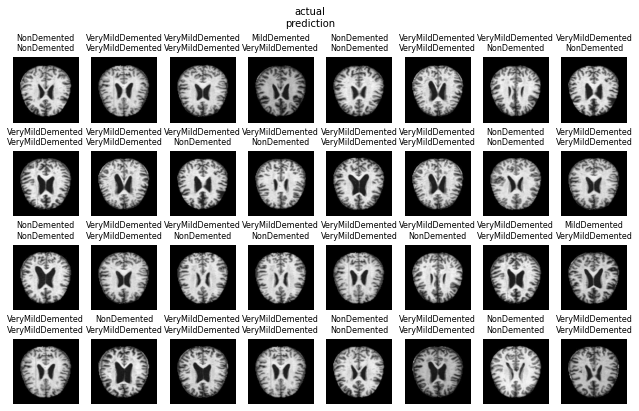

In [25]:
alzheimer_model_inception = model
alzheimer_model_inception.trainable = False
image_batch, label_batch = next(iter(test_ds_OHE))
preds_batch = alzheimer_model_inception(image_batch).numpy()
yhat_batch = np.argmax(preds_batch,axis=1)
m = image_batch.shape[0]
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(11, 6.5))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

from termcolor import colored
for a in ax.flat:
    random_index = np.random.randint(m)
    a.imshow(image_batch[random_index].numpy().astype("uint8"))
    print_data = class_names[np.argmax(label_batch[random_index])]
    print_pred = class_names[yhat_batch[random_index]]
    title = f"{print_data}\n{print_pred}"
    a.set_title(title,fontsize = 8)
    a.set_axis_off()

fig.suptitle('actual\nprediction',fontsize=10)
plt.show()